In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import statistics

In [212]:
class WaveformProcessor:
    """
    Base class for storing and processing waveform data from different boards
    """
    def __init__(self, name=None):
        self.name = name or "Unnamed"
        self.channels = {}  # Main data structure

    def get_available_channels(self):
        return sorted(list(self.channels.keys()))

    def get_trace_data(self, waveform_type, channel, trace_index):
        if channel not in self.channels:
            raise ValueError(f"Channel {channel} not found")  
        if waveform_type not in self.channels[channel]:
            raise ValueError(f"Channel {channel} does not have {waveform_type} data")
        if trace_index not in self.channels[channel][waveform_type]:
            raise ValueError(f"Channel {channel} does not have trace {trace_index} in {waveform_type} data. There are {len(self.channels[channel][waveform_type].keys())} traces available.")
        return self.channels[channel][waveform_type][trace_index]['data']

    def get_trace_analysis(self, waveform_type, channel, trace_index):
        if channel not in self.channels:
            raise ValueError(f"Channel {channel} not found")  
        if waveform_type not in self.channels[channel]:
            raise ValueError(f"Channel {channel} does not have {waveform_type} data")
        if trace_index not in self.channels[channel][waveform_type]:
            raise ValueError(f"Channel {channel} does not have trace {trace_index} in {waveform_type} data. There are {len(self.channels[channel][waveform_type].keys())} traces available.")
        return self.channels[channel][waveform_type][trace_index]['analysis']

    def get_pedestal(self, data, baseline_start_pct, baseline_end_pct):
        start_idx = int(len(data) * baseline_start_pct)
        end_idx = int(len(data) * baseline_end_pct)
        return np.mean(data[start_idx:end_idx+1])

    def getPeakIndex(self, data, baseline_start_pct, baseline_end_pct, threshold, true_peak=False):
        peak_value = 0
        peak_index = 0
        threshold_index = 0
        crossed_threshold = False
        counter = 0
        counter_max = 2 
        ## May want to add a counter_max for different scope resolutions    
        # if self.name=='CASB1':
        #     counter_max = 8 # traces sampled with 100 ps resolution scope -
        # elif self.name=='CASB2': 
        #     counter_max = 2 # traces sampled with 400 ps resulution scope 
    
        pedestal = self.get_pedestal(data, baseline_start_pct, baseline_end_pct)
        for i in range(len(data)):
            if not crossed_threshold and data[i]-pedestal>threshold:
                crossed_threshold = True
                threshold_index = i
            if crossed_threshold and data[i]<=peak_value:
                counter += 1
            if crossed_threshold and data[i]>peak_value:
                peak_value = data[i]
                peak_index = i
            if crossed_threshold and counter>counter_max:
                break

        if true_peak:
            peak_index = np.argmax(data)
            
        return peak_index, threshold_index

    
    def getLowCrossingTime(self,time,data,thresh,start_i):
        over=0
        under=0
        for i in range(start_i,-1,-1):
            if data[i]<thresh:
                under=i
                over=i+1
                break
        m=(data[over]-data[under])/(time[over]-time[under])
        cross_time=time[under]+((thresh-data[under])/m)
        return cross_time

    def getHighCrossingTime(self,time,data,thresh,start_i):
        over=0
        under=0
        for i in range(start_i,len(data)):
            if data[i]>thresh:
                over=i
                under=i-1
                break
        m=(data[over]-data[under])/(time[over]-time[under])
        cross_time=time[under]+((thresh-data[under])/m)
        return cross_time

    def calculate_rise_time(self, channel, waveform_type, trace_index, baseline_start_pct, baseline_end_pct, threshold, low_pct, high_pct,output,input):
        df = self.get_trace_data(waveform_type, channel, trace_index)
        time = df["time"].values * 1e9 # Convert to ns
        if output:
            signal = df["output"].values * 1e3 # Convert to mV
        elif input:
            signal = df["input"].values * 1e3 # Convert to mV
        pedestal = self.get_pedestal(signal, baseline_start_pct, baseline_end_pct)
        peak_index,threshold_index = self.getPeakIndex(signal, baseline_start_pct, baseline_end_pct, threshold)
        amplitude = signal[peak_index] - pedestal
        low_threshold = pedestal + amplitude * low_pct 
        high_threshold = pedestal + amplitude * high_pct
        t_low=self.getLowCrossingTime(time,signal,low_threshold,threshold_index)
        t_high=self.getHighCrossingTime(time,signal,high_threshold,threshold_index)
        rise_time = t_high - t_low
        if output:
            analysis_dict = self.channels[channel][waveform_type][trace_index].get('analysis', {})
            analysis_dict.update({
                "output_rise_time": rise_time,
                "output_t_low": t_low,
                "output_t_high": t_high,
                "output_peak": signal[peak_index],
                "output_peak_index": peak_index,
                "output_pedestal": pedestal
            })
            self.channels[channel][waveform_type][trace_index]['analysis'] = analysis_dict
        elif input:
            analysis_dict = self.channels[channel][waveform_type][trace_index].get('analysis', {})
            analysis_dict.update({
                "input_rise_time": rise_time,
                "input_t_low": t_low,
                "input_t_high": t_high,
                "input_peak": signal[peak_index],
                "input_peak_index": peak_index,
                "input_pedestal": pedestal
            })
            self.channels[channel][waveform_type][trace_index]['analysis'] = analysis_dict
        else:
            raise ValueError("Please specify if a CASB input or output trace is being analyzed")
        return rise_time, t_low, t_high
    
    def calculate_all_rise_times(self, waveform_type, baseline_start_pct, baseline_end_pct, threshold, low_pct, high_pct,output,input):
        results = {}
        for channel in self.channels:
            try:
                if waveform_type in self.channels[channel]:
                    for trace_index in range(len(self.channels[channel][waveform_type])):
                        rt, t_low, t_high = self.calculate_rise_time(channel,waveform_type,trace_index,baseline_start_pct,baseline_end_pct,threshold,low_pct,high_pct,output,input)
                        results[channel] = rt
                else:
                    results[channel] = np.nan
            except Exception as e:
                print(f"Error processing {self.name} {waveform_type} channel {channel}: {e}")
                results[channel] = np.nan
        return results
    
    # def calculate_delays(self, waveform_type='averages', trace_index=0, reference_channel=None):
    #     channels_with_rt = {}
    #     for ch in self.channels:
    #         if ('analysis' in self.channels[ch] and 
    #             'rise_time' in self.channels[ch]['analysis']):
    #             channels_with_rt[ch] = self.channels[ch]['analysis']['rise_time']
    #     if not channels_with_rt:
    #         print("No rise time measurements found. Calculating...")
    #         self.calculate_all_rise_times(waveform_type, trace_index)
    #         channels_with_rt = {}
    #         for ch in self.channels:
    #             if ('analysis' in self.channels[ch] and 
    #                 'rise_time' in self.channels[ch]['analysis']):
    #                 channels_with_rt[ch] = self.channels[ch]['analysis']['rise_time']
    #         if not channels_with_rt:
    #             raise ValueError("Failed to calculate rise times. Cannot calculate delays.")
    #     if reference_channel is None:
    #         min_rt = float('inf')
    #         for ch, rt_data in channels_with_rt.items():
    #             if not np.isnan(rt_data['value']) and rt_data['value'] < min_rt:
    #                 min_rt = rt_data['value']
    #                 reference_channel = ch
    #         if reference_channel is None:
    #             raise ValueError("No valid rise time found for any channel.")
    #     if reference_channel not in channels_with_rt:
    #         raise ValueError(f"Reference channel {reference_channel} has no rise time data")
    #     ref_t_low = channels_with_rt[reference_channel]['t_low']
    #     delays = {}
    #     for ch in self.channels:
    #         if ('analysis' in self.channels[ch][waveform_type][trace_index] and 
    #             'rise_time' in self.channels[ch][waveform_type][trace_index]['analysis'] and 
    #             not np.isnan(self.channels[ch][waveform_type][trace_index]['analysis']['rise_time']['t_low'])):
    #             ch_t_low = self.channels[ch]['analysis']['rise_time']['t_low']
    #             delay_ps = (ch_t_low - ref_t_low) * 1e12
    #             if 'analysis' not in self.channels[ch]:
    #                 self.channels[ch]['analysis'] = {}
    #             self.channels[ch]['analysis']['delay'] = {
    #                 'value': delay_ps,
    #                 'reference_channel': reference_channel,
    #                 'source': waveform_type,
    #                 'trace_index': trace_index
    #             }
    #             delays[ch] = delay_ps
    #         else:
    #             delays[ch] = np.nan
    #     return delays
    
    # def calculate_gains(self, waveform_type='averages', trace_index=0):
    #     gains = {}
    #     for ch in self.channels:
    #         try:
    #             if (waveform_type in self.channels[ch] and 
    #                 trace_index in self.channels[ch][waveform_type]):
    #                 df = self.get_trace_data(waveform_type, ch, trace_index)
    #                 if "input" in df.columns and ("output" in df.columns or "amplitude" in df.columns):
    #                     input_signal = df["input"].values
    #                     output_signal = df["amplitude"].values if "amplitude" in df.columns else df["output"].values
    #                     input_pedestal = self.get_pedestal(input_signal)
    #                     output_pedestal = self.get_pedestal(output_signal)
    #                     input_adj = input_signal - input_pedestal
    #                     output_adj = output_signal - output_pedestal
    #                     input_peak = np.max(np.abs(input_adj))
    #                     output_peak = np.max(np.abs(output_adj))
    #                     if input_peak != 0:
    #                         gain = output_peak / input_peak
    #                     else:
    #                         gain = np.nan
    #                     if 'analysis' not in self.channels[ch]:
    #                         self.channels[ch]['analysis'] = {}
    #                     self.channels[ch]['analysis']['gain'] = {
    #                         'value': gain,
    #                         'input_peak': input_peak,
    #                         'output_peak': output_peak,
    #                         'source': waveform_type,
    #                         'trace_index': trace_index
    #                     }
    #                     gains[ch] = gain
    #                     print(f"Channel {ch}: Gain = {gain:.4f}")
    #                 else:
    #                     print(f"Channel {ch} missing input or output data")
    #                     gains[ch] = np.nan
    #             else:
    #                 print(f"No {waveform_type} data for channel {ch} at index {trace_index}")
    #                 gains[ch] = np.nan
    #         except Exception as e:
    #             print(f"Error calculating gain for channel {ch}: {e}")
    #             gains[ch] = np.nan
    #     return gains
    
    def plot_waveform(self, channel, waveform_type, trace_index, show_rise_time_analysis,output,input):
        fig, ax = plt.subplots(figsize=(10, 6))
        df = self.get_trace_data(waveform_type, channel, trace_index)
        analysis = self.get_trace_analysis(waveform_type, channel, trace_index)
        time_ns = df["time"].values*1e9  
        if output:
            signal_mV = df["output"].values*1e3
            ax.plot(time_ns, signal_mV - analysis['output_pedestal'],color='blue',label=f"rt={analysis['output_rise_time']:.2f} ns")
            if (show_rise_time_analysis):
                ax.axvline(x=analysis['output_t_low'], color='blue', linestyle='--') 
                ax.axvline(x=analysis['output_t_high'], color='blue', linestyle='--') 
                ax.axhline(y=0, color='grey', linestyle='--')
                ax.axhline(y=analysis['output_peak']-analysis['output_pedestal'], color='blue', linestyle='--')
        if input:
            signal_mV = df["input"].values*1e3
            ax.plot(time_ns, signal_mV - analysis['input_pedestal'],color='orange',label=f"rt={analysis['input_rise_time']:.2f} ns")
            if (show_rise_time_analysis):
                ax.axvline(x=analysis['input_t_low'], color='orange', linestyle='--') 
                ax.axvline(x=analysis['input_t_high'], color='orange', linestyle='--') 
                ax.axhline(y=0, color='grey', linestyle='--')
                ax.axhline(y=analysis['input_peak']-analysis['input_pedestal'], color='orange', linestyle='--')
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Amplitude")
        ax.set_title(f"{self.name} Channel {channel} {waveform_type} Trace {trace_index} ")
        ax.grid(True)
        plt.tight_layout()
        plt.legend()
        return fig

    def plot_all_waveforms(self, waveform_type, show_rise_time_analysis=False,output=True,input=False):
        available_traces = []
        for channel in self.channels:
            if waveform_type in self.channels[channel]:
                for trace_index in range(len(self.channels[channel][waveform_type])):
                    available_traces.append(self.channels[channel][waveform_type][trace_index])
        n_cols = 4
        n_rows = len(available_traces)//n_cols+1
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,5*n_rows))
        for i, trace in enumerate(available_traces):
            df=trace['data']
            analysis=trace['analysis']
            ax = axs[i//n_cols, i%n_cols]
            if output:
                ax.plot(df['time']*1e9, df['output']*1e3-analysis['output_pedestal'],color='blue',label=f"rt={analysis['output_rise_time']:.2f} ns")
                if show_rise_time_analysis:
                    ax.axvline(x=analysis['output_t_low'], color='blue', linestyle='--')
                    ax.axvline(x=analysis['output_t_high'], color='blue', linestyle='--') 
                    ax.axhline(y=0, color='grey', linestyle='--')
                    ax.axhline(y=analysis['output_peak']-analysis['output_pedestal'], color='blue', linestyle='--')
            if input:
                ax.plot(df['time']*1e9, df['input']*1e3-analysis['input_pedestal'],color='orange',label=f"rt={analysis['input_rise_time']:.2f} ns")
                if show_rise_time_analysis:
                    ax.axvline(x=analysis['input_t_low'], color='orange', linestyle='--')
                    ax.axvline(x=analysis['input_t_high'], color='orange', linestyle='--') 
                    ax.axhline(y=0, color='grey', linestyle='--')
                    ax.axhline(y=analysis['input_peak']-analysis['input_pedestal'], color='orange', linestyle='--')
            ax.set_title(f"{self.name} channel {channel} {waveform_type} trace {i} ")
            ax.set_xlabel('Time (ns)')
            ax.set_ylabel('Amplitude (mV)')
            ax.legend()
        plt.tight_layout

    # def plot_delays(self, highlight_extremes=True):
    #     channels_with_delays = {}
    #     for ch in self.channels:
    #         if ('analysis' in self.channels[ch] and 
    #             'delay' in self.channels[ch]['analysis']):
    #             channels_with_delays[ch] = self.channels[ch]['analysis']['delay']['value']
    #     if not channels_with_delays:
    #         raise ValueError("No delay measurements found. Run calculate_delays first.")
    #     ch_nums = sorted(list(channels_with_delays.keys()))
    #     labels = [f"CH{ch}" for ch in ch_nums]
    #     delays = [channels_with_delays[ch] for ch in ch_nums]
    #     fig, ax = plt.subplots(figsize=(12, 6))
    #     bars = ax.bar(labels, delays)
    #     if highlight_extremes:
    #         non_zero_delays = [d for d in delays if d != 0]
    #         if non_zero_delays:
    #             min_idx = delays.index(min(non_zero_delays))
    #             max_idx = delays.index(max(delays))
    #             if min_idx == delays.index(0):  # If the minimum is the reference channel (0 delay)
    #                 temp_values = delays.copy()
    #                 temp_values[min_idx] = float('inf')
    #                 min_idx = temp_values.index(min(temp_values))
    #             bars[min_idx].set_color('lightgreen')
    #             bars[max_idx].set_color('tomato')
    #             ax.text(min_idx, delays[min_idx]+20, f"{delays[min_idx]:.0f}", 
    #                    ha='center', rotation=90)
    #             ax.text(max_idx, delays[max_idx]+20, f"{delays[max_idx]:.0f}", 
    #                    ha='center', rotation=90)
    #     std_dev = np.std([d for d in delays if not np.isnan(d) and d != 0])
    #     ax.set_xlabel("Channel")
    #     ax.set_ylabel("Delay Relative to Reference Channel [ps]")
    #     ax.set_title(f"{self.name} Unity Path Relative Channel Delays")
    #     ax.set_ylim(0, max(delays) * 1.2)  # Add 20% margin
    #     ax.legend([f'$\\sigma= {std_dev:.2f}$'])
    #     ax.grid(axis='y', linestyle='--', alpha=0.7)
    #     plt.tight_layout()
    #     return fig
    
    # def plot_multiple_traces(self, channel, waveform_type='singles', max_traces=5, ax=None):
    #     if channel not in self.channels or waveform_type not in self.channels[channel]:
    #         raise ValueError(f"No {waveform_type} data found for channel {channel}")
    #     traces = self.channels[channel][waveform_type]
    #     if not traces:
    #         raise ValueError(f"No traces found for channel {channel} in {wf_type}")
    #     if ax is None:
    #         fig, ax = plt.subplots(figsize=(10, 6))
    #     trace_nums = sorted(list(traces.keys()))[:max_traces]
    #     for i, trace_num in enumerate(trace_nums):
    #         df = traces[trace_num]
    #         if "output" in df.columns:
    #             label = f"Trace {trace_num}"
    #             ax.plot(df["time"] * 1e9, df["output"], label=label, alpha=0.7)
    #         elif "amplitude" in df.columns:
    #             label = f"Trace {trace_num}"
    #             ax.plot(df["time"] * 1e9, df["amplitude"], label=label, alpha=0.7)
    #     ax.set_xlabel("Time (ns)")
    #     ax.set_ylabel("Output")
    #     ax.set_title(f"{self.name} Channel {channel} - {waveform_type.capitalize()} Traces")
    #     ax.grid(True)
    #     ax.legend()
    #     return ax


In [213]:


class CASB1Processor(WaveformProcessor):
    
    def __init__(self):
        super().__init__(name="CASB1")
    
    def load_singles(self, path="../data/casb1/singles/C1--Trace--*.txt"):
        files = glob.glob(path)
        if not files:
            print(f"Warning: No files found matching pattern: {path}")
            return {}
        files_per_channel = {}
        for file in files:
            try:
                filename = os.path.basename(file)
                match = re.search(r'C(\d+)--Trace--(\d+)', filename)
                if match:
                    channel = int(match.group(1))
                    trace_num = int(match.group(2))
                else:
                    match = re.search(r'Trace--(\d+)', filename)
                    if match:
                        trace_num = int(match.group(1))
                        channel = 1  # Default if no channel in filename
                    else:
                        print(f"Could not extract info from {filename}, skipping")
                        continue
                df = pd.read_csv(file, skiprows=6, names=["time", "output"])
                for col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                if channel not in self.channels:
                    self.channels[channel] = {}
                if 'singles' not in self.channels[channel]:
                    self.channels[channel]['singles'] = {}
                self.channels[channel]['singles'][trace_num] = {
                    'data': df,
                    'analysis': {}
                }
                if channel in files_per_channel:
                    files_per_channel[channel] += 1
                else:
                    files_per_channel[channel] = 1
            except Exception as e:
                print(f"Error processing file {file}: {e}")
        total_files = sum(files_per_channel.values())
        print(f"Loaded {total_files} singles files across {len(files_per_channel)} channels for {self.name}")
        return files_per_channel
    
    def load_averages(self, path):
        files = glob.glob(path)
        if not files:
            print(f"Warning: No files found matching pattern: {path}")
            return {}
        files_per_channel = {}
        for file in files:
            try:
                filename = os.path.basename(file)
                match = re.search(r'ch(\d+)', filename)
                if match:
                    channel = int(match.group(1))
                else:
                    print(f"Could not extract channel from {filename}, skipping")
                    continue
                if channel in files_per_channel:
                    trace_num = files_per_channel[channel]
                else:
                    trace_num = 0
                df = pd.read_csv(file, skiprows=21, names=["time", "output", "input", "CH3"])
                for col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                df = df[["time", "output", "input"]] if "input" in df.columns else df[["time", "output"]]
                if channel not in self.channels:
                    self.channels[channel] = {}
                if 'averages' not in self.channels[channel]:
                    self.channels[channel]['averages'] = {}
                self.channels[channel]['averages'][trace_num] = {
                    'data': df,
                    'analysis': {}
                }
                if channel in files_per_channel:
                    files_per_channel[channel] += 1
                else:
                    files_per_channel[channel] = 1
            except Exception as e:
                print(f"Error processing file {file}: {e}")
        total_files = sum(files_per_channel.values())
        print(f"Loaded {total_files} averages files across {len(files_per_channel)} channels for {self.name}")
        return files_per_channel
    
    def load_data(self, singles_path="../data/casb1/singles/C1--Trace--*.txt", averages_path="../data/casb1/averages/new/ch*.csv"):
        singles_result = {}
        if singles_path:
            singles_result = self.load_singles(singles_path)
        averages_result = {}
        if averages_path:
            averages_result = self.load_averages(averages_path)
        return len(singles_result), len(averages_result)


In [214]:
class CASB2Processor(WaveformProcessor):
    
    def __init__(self):
        super().__init__(name="CASB2")
    
    def load_singles(self, path):
        files = glob.glob(path)
        if not files:
            print(f"Warning: No files found matching pattern: {path}")
            return {}
        files_per_channel = {}
        for file in files:
            try:
                filename = os.path.basename(file)
                ch_dir = os.path.basename(os.path.dirname(file))
                ch_match = re.search(r'ch(\d+)', ch_dir)
                if ch_match:
                    channel = int(ch_match.group(1))
                else:
                    ch_match = re.search(r'ch(\d+)', filename)
                    if ch_match:
                        channel = int(ch_match.group(1))
                    else:
                        print(f"Could not extract channel from {file}, skipping")
                        continue
                trace_match = re.search(r'tek(\d+)ALL', filename)
                if trace_match:
                    trace_num = int(trace_match.group(1))
                else:
                    if channel in files_per_channel:
                        trace_num = files_per_channel[channel]
                    else:
                        trace_num = 0
                
                df = pd.read_csv(file, skiprows=21, names=["time", "output", "input", "CH3"])
                for col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                df = df[["time", "output", "input"]] if "input" in df.columns else df[["time", "output"]]
                if channel not in self.channels:
                    self.channels[channel] = {}
                if 'singles' not in self.channels[channel]:
                    self.channels[channel]['singles'] = {}
                self.channels[channel]['singles'][trace_num] = {
                    'data': df,
                    'analysis': {}
                }
                if channel in files_per_channel:
                    files_per_channel[channel] += 1
                else:
                    files_per_channel[channel] = 1
            except Exception as e:
                print(f"Error processing file {file}: {e}")
        
        # Print summary
        total_files = sum(files_per_channel.values())
        print(f"Loaded {total_files} singles files across {len(files_per_channel)} channels for {self.name}")
        
        return files_per_channel
    
    def load_averages(self, path):
        files = glob.glob(path)
        if not files:
            print(f"Warning: No files found matching pattern: {path}")
            return {}
            
        files_per_channel = {}
        
        for file in files:
            try:
                filename = os.path.basename(file)
                ch_match = re.search(r'tek(\d+)ALL', filename)
                if ch_match:
                    channel = int(ch_match.group(1))
                else:
                    print(f"Could not extract channel from {file}, skipping")
                    continue
                if channel in files_per_channel:
                    trace_num = files_per_channel[channel]
                else:
                    trace_num = 0
                
                df = pd.read_csv(file, skiprows=21, names=["time", "output", "input", "CH3"])
                for col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                df = df[["time", "output", "input"]] if "input" in df.columns else df[["time", "output"]]
                
                if channel not in self.channels:
                    self.channels[channel] = {}
                
                if 'averages' not in self.channels[channel]:
                    self.channels[channel]['averages'] = {}
                
                self.channels[channel]['averages'][trace_num] = {
                    'data': df,
                    'analysis': {}
                }
                
                if channel in files_per_channel:
                    files_per_channel[channel] += 1
                else:
                    files_per_channel[channel] = 1
                    
            except Exception as e:
                print(f"Error processing file {file}: {e}")
        
        # Print summary
        total_files = sum(files_per_channel.values())
        print(f"Loaded {total_files} averages files across {len(files_per_channel)} channels for {self.name}")
        
        return files_per_channel
    
    def load_data(self, singles_path="../data/casb2/singles/ch*/tek*ALL.csv", averages_path="../data/casb2/averages/tek*ALL.csv"):
        singles_result = {}
        if singles_path:
            singles_result = self.load_singles(singles_path)
        else:
            singles_result = self.load_singles()  # Use default path
        
        averages_result = {}
        if averages_path:
            averages_result = self.load_averages(averages_path)
        else:
            averages_result = self.load_averages()  # Use default path
        
        return len(singles_result), len(averages_result)



In [215]:
class MTCAProcessor(WaveformProcessor):
    """Processor for MTCA board data."""
    
    def __init__(self):
        super().__init__(name="MTCA1")
    
    def load_singles(self, path):
        files = glob.glob(path)
        if not files:
            print(f"Warning: No files found matching pattern: {path}")
            return {}
            
        files_per_channel = {}
        
        for file in files:
            try:
                filename = os.path.basename(file)
                
                # Extract channel and trace info
                match = re.search(r'C(\d+)--Trace--(\d+)', filename)
                if match:
                    channel = int(match.group(1))
                    trace_num = int(match.group(2))
                else:
                    match = re.search(r'Trace--(\d+)', filename)
                    if match:
                        trace_num = int(match.group(1))
                        channel = 4  # Default if not specified
                    else:
                        print(f"Could not extract info from {filename}, skipping")
                        continue
                
                # Load data - adjust skiprows based on your file format
                df = pd.read_csv(file, skiprows=6, names=["time", "output"])
                for col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                df['output'] = df['output'] * -1
                # Initialize channel structure if needed
                if channel not in self.channels:
                    self.channels[channel] = {}
                
                # Initialize singles dict if needed
                if 'singles' not in self.channels[channel]:
                    self.channels[channel]['singles'] = {}
                
                # Store the trace
                self.channels[channel]['singles'][trace_num] = {
                    'data': df,
                    'analysis': {}
                } 
                
                # Update counter
                if channel in files_per_channel:
                    files_per_channel[channel] += 1
                else:
                    files_per_channel[channel] = 1
                    
            except Exception as e:
                print(f"Error processing file {file}: {e}")
                
        # Print summary
        total_files = sum(files_per_channel.values())
        print(f"Loaded {total_files} singles files across {len(files_per_channel)} channels for {self.name}")
        
        return files_per_channel
    
    def load_averages(self, path):
        files = glob.glob(path)
        if not files:
            print(f"Warning: No files found matching pattern: {path}")
            return {}
            
        files_per_channel = {}
        
        for file in files:
            try:
                filename = os.path.basename(file)
                match = re.search(r'ch(\d+)', filename)
                if match:
                    channel = int(match.group(1))
                else:
                    print(f"Could not extract channel from {filename}, skipping")
                    continue
                
                # Extract trace number if available, otherwise use counter
                if channel in files_per_channel:
                    trace_num = files_per_channel[channel]
                else:
                    trace_num = 0
                
                # Load data - adjust skiprows based on your file format
                df = pd.read_csv(file, skiprows=6, names=["time", "output"])
                for col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # Initialize channel structure if needed
                if channel not in self.channels:
                    self.channels[channel] = {}
                
                # Initialize singles dict if needed
                if 'averages' not in self.channels[channel]:
                    self.channels[channel]['averages'] = {}
                
                # Store the trace
                self.channels[channel]['averages'][trace_num] = {
                    'data': df,
                    'analysis': {}
                } 
                
                # Update counter
                if channel in files_per_channel:
                    files_per_channel[channel] += 1
                else:
                    files_per_channel[channel] = 1
                    
            except Exception as e:
                print(f"Error processing file {file}: {e}")
                
        # Print summary
        total_files = sum(files_per_channel.values())
        print(f"Loaded {total_files} averages files across {len(files_per_channel)} channels for {self.name}")
        
        return files_per_channel
    
    def load_data(self, singles_path="../data/mtca1/singles/C4--Trace--*.txt", averages_path="Don't have MTCA averages yet"):
        singles_result = {}
        if singles_path:
            singles_result = self.load_singles(singles_path)
        else:
            singles_result = self.load_singles()  # Use default path
        
        averages_result = {}
        if averages_path:
            averages_result = self.load_averages(averages_path)
        else:
            try:
                averages_result = self.load_averages()  # Use default path
            except Exception as e:
                print(f"Warning: Could not load averages with default path: {e}")
        
        return len(singles_result), len(averages_result)


In [216]:


def plot_combined_delays(boards, waveform_type='averages', trace_index=0, highlight_extremes=True):
    """
    Create a combined bar plot showing delays from multiple boards.
    
    Args:
        boards (list): List of WaveformProcessor instances
        waveform_type (str): 'singles' or 'averages'
        trace_index (int): Index of the trace to use
        highlight_extremes (bool): Whether to highlight min/max delays
        
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    # Make sure all boards have delay analysis
    for board in boards:
        channels_with_delays = 0
        for ch in board.channels:
            if ('analysis' in board.channels[ch] and 
                'delay' in board.channels[ch]['analysis']):
                channels_with_delays += 1
        
        if channels_with_delays == 0:
            print(f"Calculating delays for {board.name} using {waveform_type}[{trace_index}]")
            try:
                board.calculate_delays(waveform_type, trace_index)
            except Exception as e:
                print(f"Warning: Could not calculate delays for {board.name}: {e}")
    
    # Get all channels across all boards
    all_channels = set()
    for board in boards:
        all_channels.update(board.channels.keys())
    all_channels = sorted(list(all_channels))
    
    # Create labels
    labels = [f"CH{ch}" for ch in all_channels]
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Calculate positions for bars
    x = np.arange(len(labels))
    width = 0.8 / len(boards)  # Width of the bars, adjusted for number of boards
    
    # Plot bars for each board
    legend_items = []
    
    for i, board in enumerate(boards):
        # Create dictionary mapping channel to delay
        delay_dict = {}
        for ch in board.channels:
            if ('analysis' in board.channels[ch] and 
                'delay' in board.channels[ch]['analysis']):
                delay_dict[ch] = board.channels[ch]['analysis']['delay']['value']
        
        # Fill in delays for all channels (use NaN for missing channels)
        delays = [delay_dict.get(ch, np.nan) for ch in all_channels]
        
        # Calculate position adjustment
        pos_adjustment = width * (i - (len(boards) - 1) / 2)
        
        # Create bars
        bars = ax.bar(x + pos_adjustment, delays, width, label=board.name)
        
        if highlight_extremes:
            # Find non-NaN values
            valid_delays = [(idx, d) for idx, d in enumerate(delays) if not np.isnan(d)]
            if valid_delays:
                valid_indices, valid_values = zip(*valid_delays)
                
                # Find min (excluding 0 which might be reference)
                non_zero_values = [d for d in valid_values if d != 0]
                if non_zero_values:
                    min_val = min(non_zero_values)
                    min_idx = valid_indices[valid_values.index(min_val)]
                    max_val = max(valid_values)
                    max_idx = valid_indices[valid_values.index(max_val)]
                    
                    # Highlight min/max bars
                    bars[min_idx].set_color('lightgreen')
                    bars[max_idx].set_color('tomato')
                    
                    # Add value labels
                    ax.text(x[min_idx] + pos_adjustment, delays[min_idx]+20, 
                           f"{delays[min_idx]:.0f}", ha='center', rotation=90, fontsize=8)
                    ax.text(x[max_idx] + pos_adjustment, delays[max_idx]+20, 
                           f"{delays[max_idx]:.0f}", ha='center', rotation=90, fontsize=8)
        
        # Calculate standard deviation for legend
        valid_delays = [d for d in delays if not np.isnan(d) and d != 0]
        std_dev = np.std(valid_delays) if valid_delays else 0
        legend_items.append(f'{board.name} ($\\sigma= {std_dev:.2f}$)')
    
    # Customize the plot
    ax.set_xlabel("Channel")
    ax.set_ylabel("Delay Relative to Reference Channel [ps]")
    ax.set_title(f"Unity Path Relative Channel Delays Comparison ({waveform_type})")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    
    # Find appropriate y-limit - skip NaN and inf values
    all_delays = []
    for board in boards:
        for ch in board.channels:
            if ('analysis' in board.channels[ch] and 
                'delay' in board.channels[ch]['analysis']):
                value = board.channels[ch]['analysis']['delay']['value']
                if not np.isnan(value) and not np.isinf(value):
                    all_delays.append(value)
    
    if all_delays:
        max_delay = max(all_delays)
        ax.set_ylim(0, max_delay * 1.2)  # Add 20% margin
    
    # Add legend with standard deviations
    ax.legend(legend_items)
    
    # Add grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig


In [217]:
def histogram_board_rise_times(boards, waveform_type):
    board_rise_times = {}
    for board in boards:
        rise_times = []
        for channel in board.channels:
            if waveform_type in board.channels[channel]:
                for trace_num in board.channels[channel][waveform_type]:
                    analysis = board.channels[channel][waveform_type][trace_num]['analysis']
                    rise_times.append(analysis['output_rise_time'])
        board_rise_times[board.name] = rise_times
    # Determine shared bins
    all_data = []
    for board in board_rise_times:
        for rise_time in board_rise_times[board]:   
            all_data.append(rise_time)
    bins = np.arange(np.floor(min(all_data)*4)/4, np.ceil(max(all_data)*4)/4, 0.25)
    for board in board_rise_times:
        plt.hist(board_rise_times[board], bins=bins, density=True, histtype='step',label=board)
    plt.xlabel('Rise Time [ps]')
    plt.ylabel('Frequency')
    plt.title(f'Comparason of Different Summing Boards Rise Times')
    plt.legend()
    plt.show()

In [224]:
low_pct = 0.3
high_pct = 0.7






In [225]:


casb1 = CASB1Processor();
casb1.load_data();
casb1.calculate_all_rise_times(waveform_type='singles', baseline_start_pct=0.6, baseline_end_pct=1, threshold=8, low_pct=low_pct, high_pct=high_pct,output=True,input=False);
#casb1.plot_waveform(channel=1, waveform_type='singles', trace_index=0, show_rise_time_analysis=True,output=True,input=False);
#casb1.plot_all_waveforms(waveform_type='singles', show_rise_time_analysis=True,output=True,input=False);

Loaded 30 singles files across 1 channels for CASB1
Loaded 20 averages files across 20 channels for CASB1


In [226]:

casb2 = CASB2Processor();
casb2.load_data();
casb2.calculate_all_rise_times(waveform_type='singles', baseline_start_pct=0, baseline_end_pct=0.4, threshold=8, low_pct=low_pct, high_pct=high_pct,output=True,input=False);
casb2.calculate_all_rise_times(waveform_type='singles', baseline_start_pct=0.8, baseline_end_pct=1, threshold=10, low_pct=low_pct, high_pct=high_pct,output=False,input=True);
#casb2.plot_waveform(channel=6, waveform_type='singles', trace_index=5, show_rise_time_analysis=True,output=True,input=True);
#casb2.plot_all_waveforms(waveform_type='singles', show_rise_time_analysis=True);



Loaded 400 singles files across 20 channels for CASB2
Loaded 20 averages files across 20 channels for CASB2


In [227]:
mtca1 = MTCAProcessor();
mtca1.load_data();
mtca1.calculate_all_rise_times(waveform_type='singles',baseline_start_pct=0,baseline_end_pct=0.2,threshold=10,low_pct=low_pct,high_pct=high_pct,output=True,input=False);

#mtca1.plot_waveform(channel=4,waveform_type='singles',trace_index=0,show_rise_time_analysis=True,output=True,input=False);
#mtca1.plot_all_waveforms(waveform_type='singles',show_rise_time_analysis=True,output=True,input=False);

Loaded 35 singles files across 1 channels for MTCA1


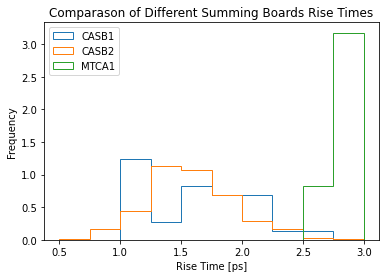

In [228]:
histogram_board_rise_times([casb1, casb2, mtca1], waveform_type='singles')

In [223]:




#mtca1.calculate_all_rise_times()

# # Calculate delays using averages data
# casb1.calculate_delays(waveform_type='averages', trace_index=0)
# casb2.calculate_delays(waveform_type='averages', trace_index=0)
# mtca.calculate_delays(waveform_type='averages', trace_index=0)

# # Calculate gains using averages data
# casb1.calculate_gains(waveform_type='averages', trace_index=0)
# casb2.calculate_gains(waveform_type='averages', trace_index=0)
# mtca.calculate_gains(waveform_type='averages', trace_index=0)

# # Plot a sample waveform
#casb2.plot_all_waveforms(waveform_type='singles', show_rise_time_analysis=True);
#mtca1.plot_all_waveforms(waveform_type='singles', show_rise_time_analysis=True);_

# # Plot delays for individual boards
# casb1.plot_delays(highlight_extremes=True)
# casb2.plot_delays(highlight_extremes=True)

# # Plot combined delays
# plot_combined_delays([casb1, casb2, mtca], waveform_type='averages', trace_index=0)